# Control Engineering with gwexpy - Part 0: Discretization Basics (Theory)

**Topic**: Continuous vs Discrete Systems (ZOH, Tustin).

This notebook serves as the **theoretical foundation** for the Control Engineering Tutorial Series. It demonstrates how continuous-time systems (like the ones we model and control in later parts) are discretized for digital implementation.

## Tutorial Series Index
1.  **[Part 1: Data & Spectral Basics](tutorial_Control_01_Basics.ipynb)**: Generating and analyzing data (ASD, Transfer Functions).
2.  **[Part 2: Modeling](tutorial_Control_02_Modeling.ipynb)**: Measuring Frequency Response and fitting a model ($P(s)$).
3.  **[Part 3: Controller Design](tutorial_Control_03_Design.ipynb)**: Designing a loop ($K(s)$) and verifying it.

---

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import bode, c2d, lsim, pole, step, tf, zero

import gwexpy
from gwexpy import FrequencySeries, TimeSeries

print(f"gwexpy version: {gwexpy.__version__}")
print(f"control version: {control.__version__}")

gwexpy version: 0.1.0b1
control version: 0.10.2


## 1. Continuous Time System Model

We define a simple first-order continuous-time transfer function:
$$ P(s) = \frac{1}{0.5s + 1} $$

In [2]:
# Define Transfer Function P(s) = 1 / (0.5s + 1)
num = [0, 1]
den = [0.5, 1]
P = tf(num, den)
print("Continuous Time System P(s):")
print(P)

Continuous Time System P(s):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      1
  ---------
  0.5 s + 1


In [3]:
# Check poles and zeros
print(f"Poles: {pole(P)}")
print(f"Zeros: {zero(P)}")

Poles: [-2.+0.j]
Zeros: []


## 2. Discretization

We will convert the continuous system to discrete-time systems using two methods with a sampling time $t_s = 0.2s$:
1.  **Zero-Order Hold (ZOH)**: Good for step response (time domain).
2.  **Bilinear Transformation (Tustin)**: Good for frequency response (frequency domain).

In [4]:
ts = 0.2  # Sampling time (seconds)

# 1. Zero-Order Hold
Pd_zoh = c2d(P, ts, method="zoh")
print("Discrete System (ZOH):")
print(Pd_zoh)

# 2. Bilinear (Tustin)
Pd_tustin = c2d(P, ts, method="tustin")
print("\nDiscrete System (Tustin):")
print(Pd_tustin)

Discrete System (ZOH):
<TransferFunction>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.2

    0.3297
  ----------
  z - 0.6703

Discrete System (Tustin):
<TransferFunction>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.2

  0.1667 z + 0.1667
  -----------------
     z - 0.6667


## 3. Frequency Response (Bode Plot)

We compare the frequency responses. Note how Tustin matches the continuous phase better at high frequencies.
We use `gwexpy.FrequencySeries` for plotting to leverage its unit handling.

In [5]:
# Calculate Bode data
omega = np.logspace(-2, 2, 100)

mag_c, phase_c, w_c = bode(P, omega, plot=False)
mag_z, phase_z, w_z = bode(Pd_zoh, omega, plot=False)
mag_t, phase_t, w_t = bode(Pd_tustin, omega, plot=False)

# Convert to gwexpy FrequencySeries
# Note: control.bode returns magnitude (not dB) and phase in radians.
# We define units explicitly.

fs_mag_c = FrequencySeries(
    20 * np.log10(mag_c), frequencies=w_c, unit="dB", name="Continuous (Mag)"
)
fs_mag_z = FrequencySeries(
    20 * np.log10(mag_z), frequencies=w_z, unit="dB", name="ZOH (Mag)"
)
fs_mag_t = FrequencySeries(
    20 * np.log10(mag_t), frequencies=w_t, unit="dB", name="Tustin (Mag)"
)

fs_phase_c = FrequencySeries(
    np.rad2deg(phase_c), frequencies=w_c, unit="deg", name="Continuous (Phase)"
)
fs_phase_z = FrequencySeries(
    np.rad2deg(phase_z), frequencies=w_z, unit="deg", name="ZOH (Phase)"
)
fs_phase_t = FrequencySeries(
    np.rad2deg(phase_t), frequencies=w_t, unit="deg", name="Tustin (Phase)"
)  # fixed: was w_z

<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/lti.py:138: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/lti.py:138: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/freqplot.py:454: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


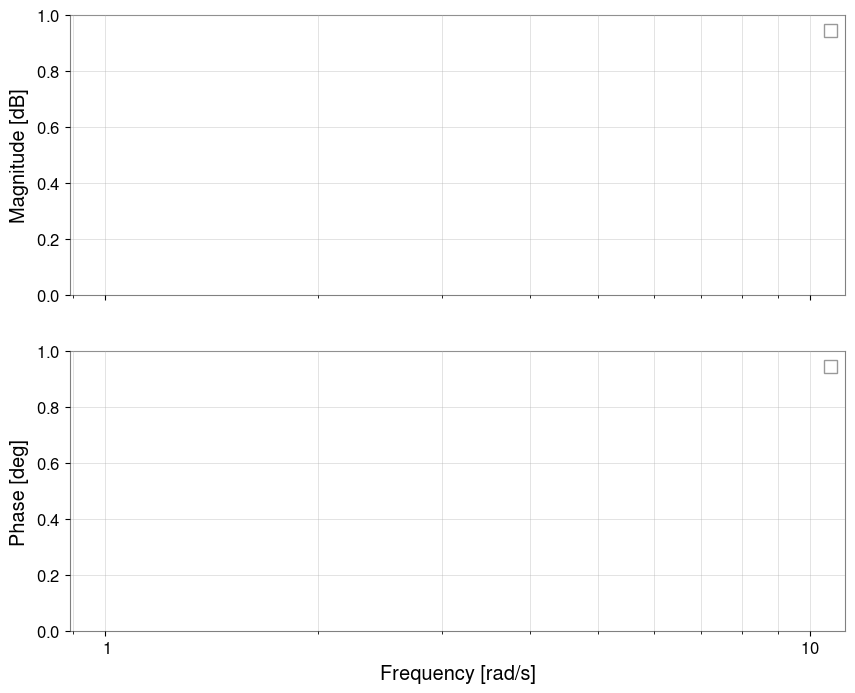

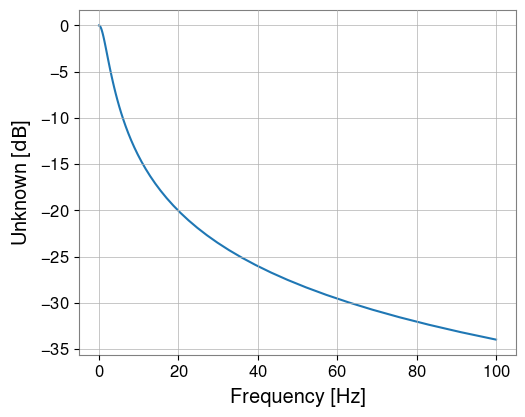

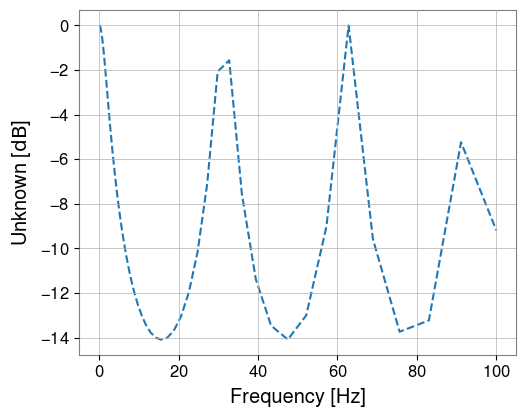

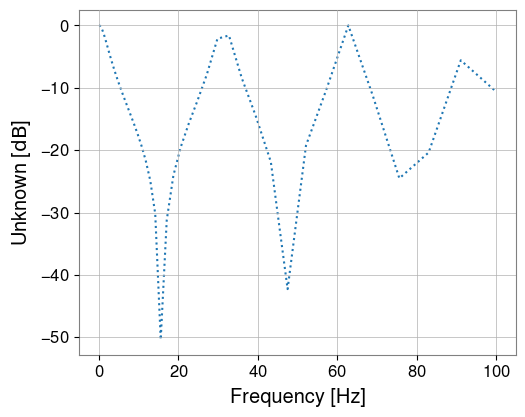

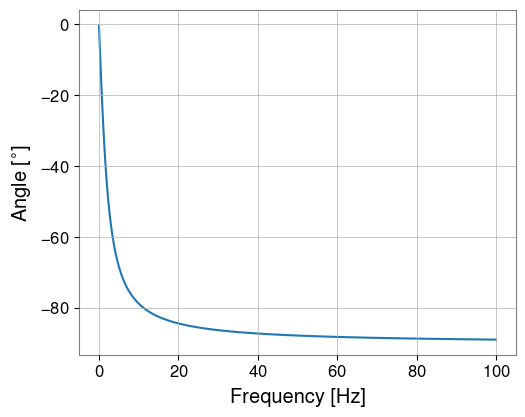

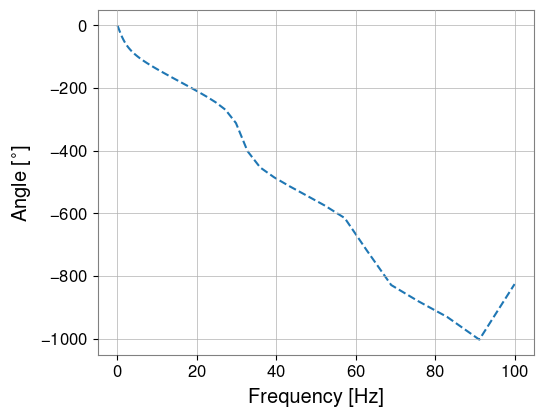

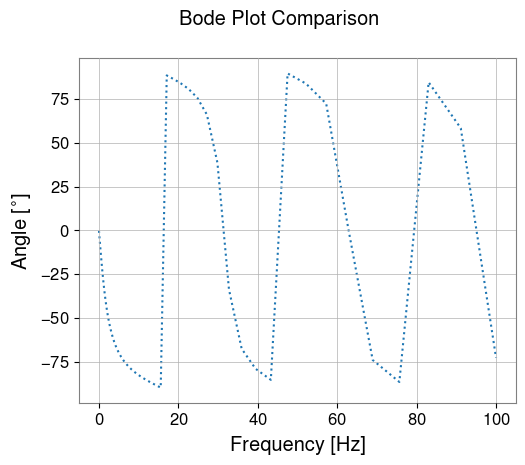

In [6]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

fs_mag_c.plot(ax=ax1, label="Continuous")
fs_mag_z.plot(ax=ax1, label="ZOH", linestyle="--")
fs_mag_t.plot(ax=ax1, label="Tustin", linestyle=":")
ax1.set_xscale("log")
ax1.set_ylabel("Magnitude [dB]")
ax1.legend()
ax1.grid(which="both", linestyle="-", alpha=0.5)

fs_phase_c.plot(ax=ax2, label="Continuous")
fs_phase_z.plot(ax=ax2, label="ZOH", linestyle="--")
fs_phase_t.plot(ax=ax2, label="Tustin", linestyle=":")
ax2.set_xscale("log")
ax2.set_ylabel("Phase [deg]")
ax2.set_xlabel("Frequency [rad/s]")
ax2.legend()
ax2.grid(which="both", linestyle="-", alpha=0.5)

plt.suptitle("Bode Plot Comparison")
plt.show()

## 4. Time Domain: Step Response

ZOH is accurate for step responses since the input is held constant between samples.

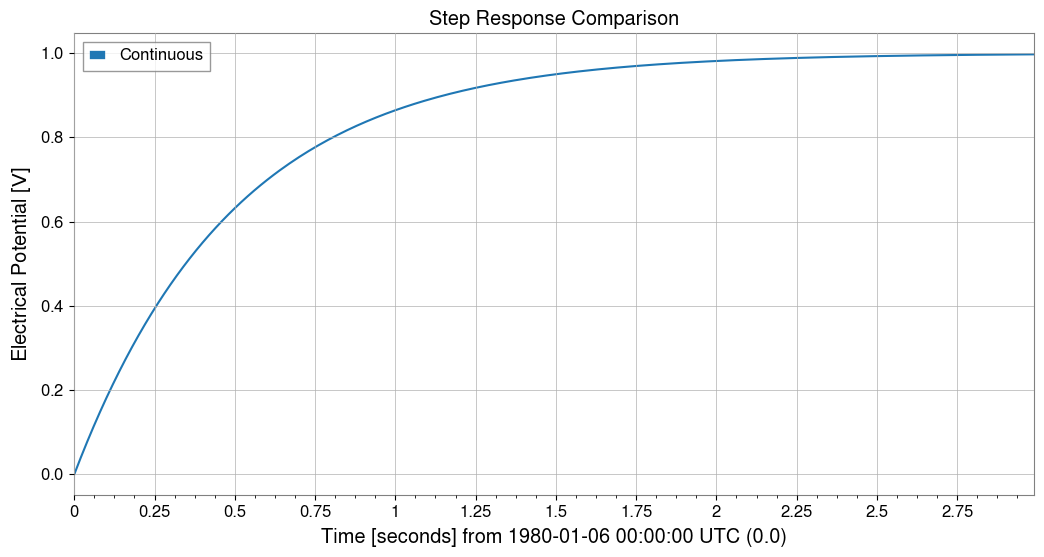

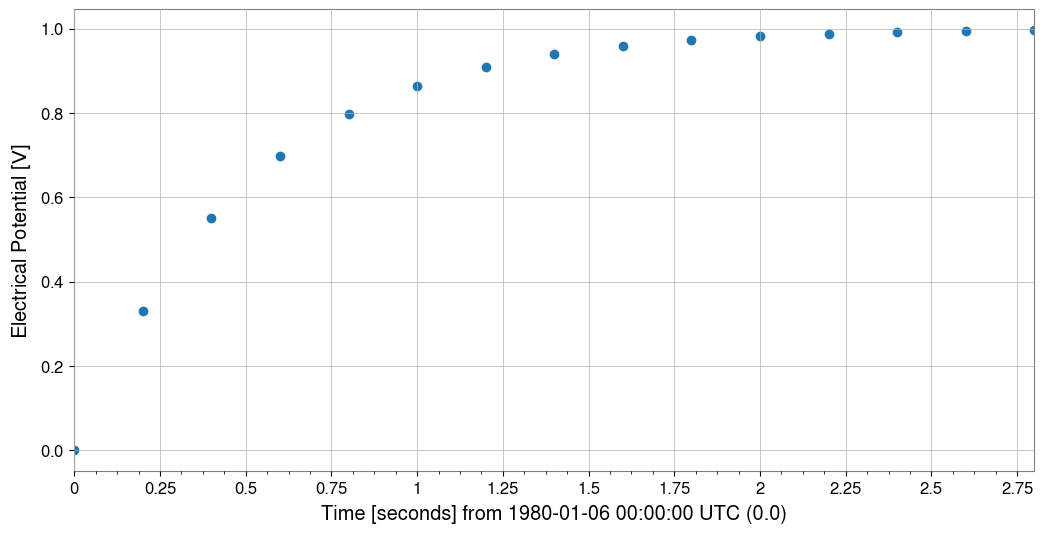

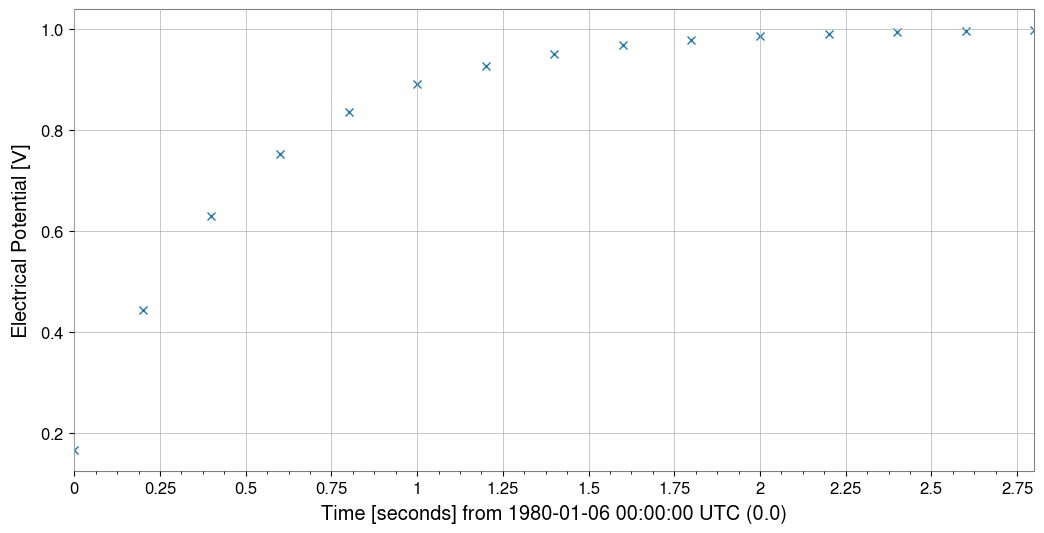

In [7]:
T_end = 3
Tc = np.arange(0, T_end, 0.01)
Td = np.arange(0, T_end, ts)

# Step Response
yc, tc = step(P, Tc)
yd_z, td_z = step(Pd_zoh, Td)
yd_t, td_t = step(Pd_tustin, Td)

# Wrap in gwexpy TimeSeries
ts_c = TimeSeries(yc, times=tc, unit="V", name="Continuous")
ts_z = TimeSeries(yd_z, times=td_z, unit="V", name="ZOH")
ts_t = TimeSeries(yd_t, times=td_t, unit="V", name="Tustin")

plot = ts_c.plot(label="Continuous", title="Step Response Comparison")
ax = plot.gca()
ts_z.plot(ax=ax, label="ZOH", marker="o", linestyle="None")
ts_t.plot(ax=ax, label="Tustin", marker="x", linestyle="None")
ax.legend()
ax.grid(True)
plt.show()

## 5. Time Domain: Arbitrary Input

Response to $u(t) = 0.5\sin(6t) + 0.5\cos(8t)$.
Tustin (Bilinear) generally approximates arbitrary smooth inputs better.

<home>/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/timeresp.py:1082: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


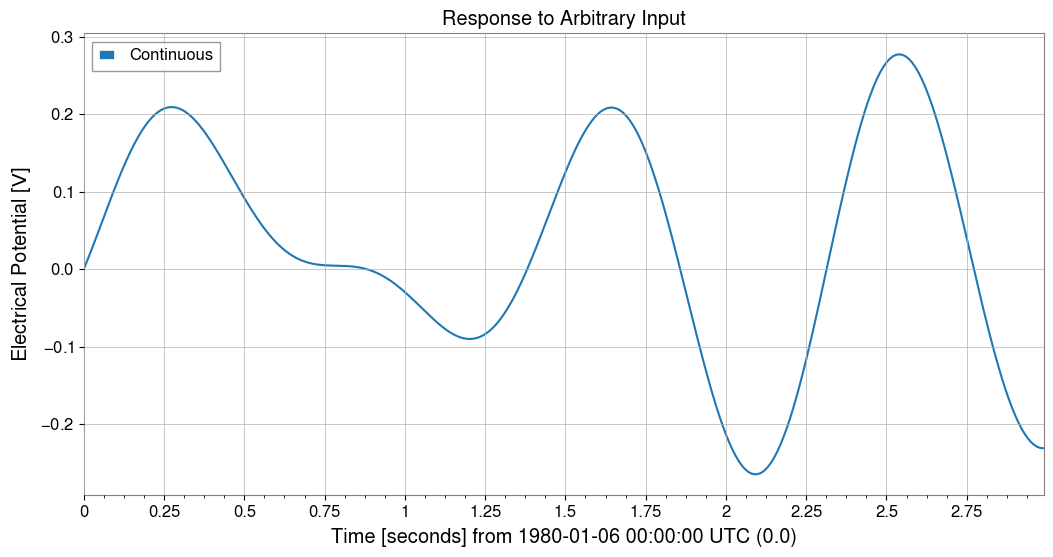

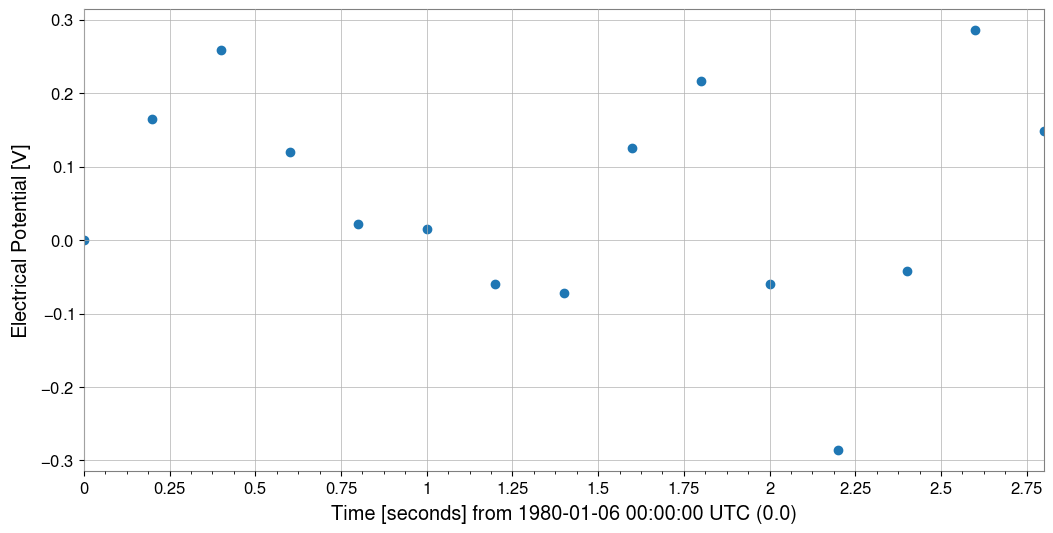

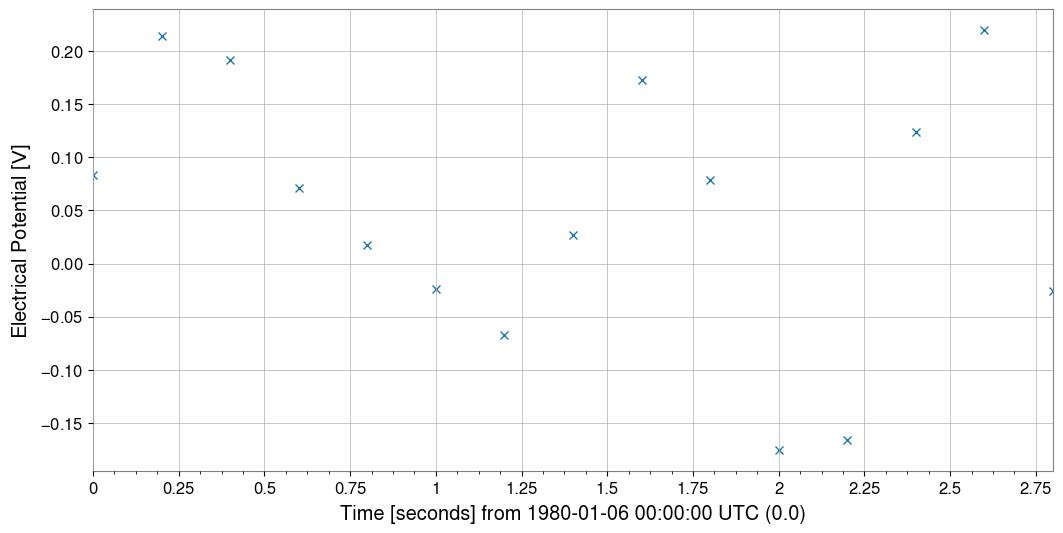

In [8]:
# Use gwexpy to generate input signal
# Continuous high-res time
t_fine = np.arange(0, 3, 0.01)
u_c_ts = TimeSeries(0.5 * np.sin(6 * t_fine) + 0.5 * np.cos(8 * t_fine), times=t_fine)

# Discrete sampling points
t_disc = np.arange(0, 3, ts)
u_d_ts = TimeSeries(0.5 * np.sin(6 * t_disc) + 0.5 * np.cos(8 * t_disc), times=t_disc)

# Simulate
yc_arb, tc_arb, _ = lsim(P, u_c_ts.value, t_fine)
yd_z_arb, td_z_arb, _ = lsim(Pd_zoh, u_d_ts.value, t_disc)
yd_t_arb, td_t_arb, _ = lsim(Pd_tustin, u_d_ts.value, t_disc)

# Wrap results
res_c = TimeSeries(yc_arb, times=tc_arb, unit="V", name="Continuous")
res_z = TimeSeries(yd_z_arb, times=td_z_arb, unit="V", name="ZOH")
res_t = TimeSeries(yd_t_arb, times=td_t_arb, unit="V", name="Tustin")

plot = res_c.plot(label="Continuous", title="Response to Arbitrary Input")
ax = plot.gca()
res_z.plot(ax=ax, label="ZOH", marker="o", linestyle="None")
res_t.plot(ax=ax, label="Tustin", marker="x", linestyle="None")
ax.legend()
ax.grid(True)
plt.show()